## 📊 Bakery Sales Prediction

**Goal**: Predict bakery sales for the next `N` days using machine learning models.

Dataset provided has dates and daily sales. The goal is to build an ML pipeline that:
- Preprocesses the data
- Builds and compares multiple models
- Validates performance
- Predicts sales for the next N days


In [1]:
# Importing Libaries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
# Suppress Warnings
warnings.filterwarnings('ignore')

In [2]:
# Load Dataset
df=pd.read_csv("dataset.csv")


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173 entries, 0 to 172
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   DATE    173 non-null    object
 1   SALES   173 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.8+ KB


## 🧾 Data Understanding

The dataset has two columns:
- `Date`: The date of the sale
- `Sales`: The number of sales made on that day

Parse the dates and perform time-based feature engineering to extract valuable insights for the models.


In [4]:
df.head()

,DATE,SALES
0,9/30/18,39
1,10/1/18,25
2,10/2/18,48
3,10/3/18,32
4,10/4/18,87


In [5]:
# Check for duplicates
df.duplicated().sum()

0

In [6]:
# Check missing values
df.isnull().sum()

DATE     0
SALES    0
dtype: int64

## 🔧 Feature Engineering

Extract the following features from the date:
- Days Count from the starting sale
- Day of the week
- Day of the month
- Month
- Whether it's a weekend


In [7]:
#data cleaning and preprocessing

from datetime import datetime, timedelta

In [8]:
df['DATE'] = pd.to_datetime(df['DATE']) #convert text to date
df = df.sort_values('DATE') # sort dates in ascending order
df['Days'] = (df['DATE'] - df['DATE'].min()).dt.days #count days from start date
df


,DATE,SALES,Days
0,2018-09-30,39,0
1,2018-10-01,25,1
2,2018-10-02,48,2
3,2018-10-03,32,3
4,2018-10-04,87,4
...,...,...,...
168,2019-03-21,32,172
169,2019-03-22,11,173
170,2019-03-23,22,174
171,2019-03-24,29,175


In [9]:
def create_features(df):
    df['dayofweek'] = df['DATE'].dt.dayofweek  # Monday = 0, Sunday = 6
    df['month'] = df['DATE'].dt.month          # Month of the year
    df['day'] = df['DATE'].dt.day              # Day of the month
    df['is_weekend'] = df['dayofweek'].apply(lambda x: 1 if x >= 5 else 0)
    df['Days'] = (df['DATE'] - df['DATE'].min()).dt.days
    return df

In [10]:
df= create_features(df)

In [11]:
df

,DATE,SALES,Days,dayofweek,month,day,is_weekend
0,2018-09-30,39,0,6,9,30,1
1,2018-10-01,25,1,0,10,1,0
2,2018-10-02,48,2,1,10,2,0
3,2018-10-03,32,3,2,10,3,0
4,2018-10-04,87,4,3,10,4,0
...,...,...,...,...,...,...,...
168,2019-03-21,32,172,3,3,21,0
169,2019-03-22,11,173,4,3,22,0
170,2019-03-23,22,174,5,3,23,1
171,2019-03-24,29,175,6,3,24,1


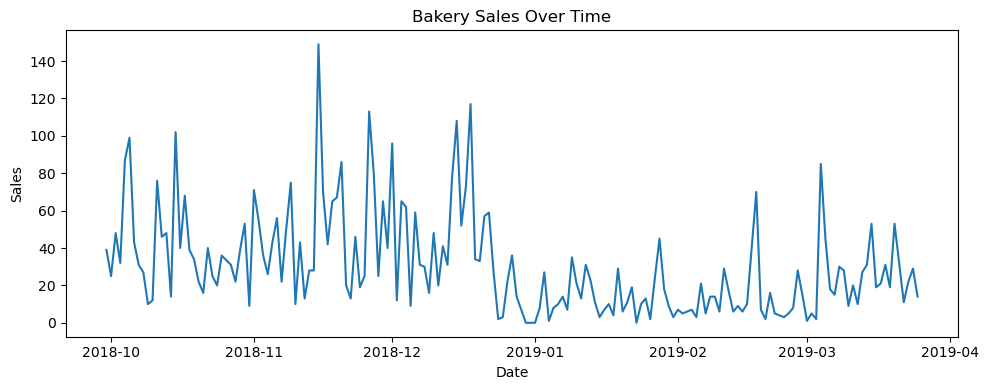

In [12]:
# Plot the sales data
plt.figure(figsize=(10, 4))
sns.lineplot(x='DATE', y='SALES', data=df)
plt.title("Bakery Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.tight_layout()
plt.show()


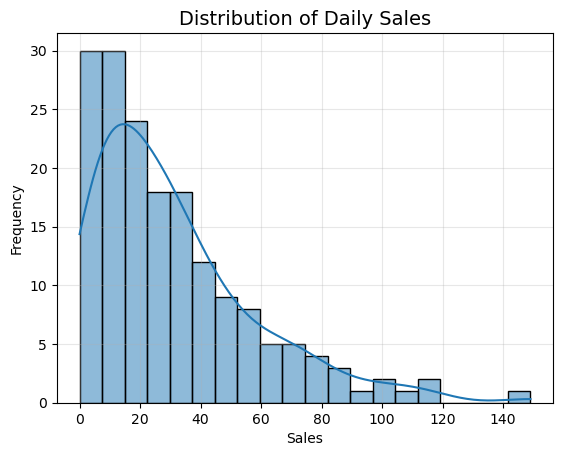

In [13]:

sns.histplot(df['SALES'], bins=20, kde=True)
plt.title('Distribution of Daily Sales', fontsize=14)
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

<Figure size 1000x400 with 0 Axes>

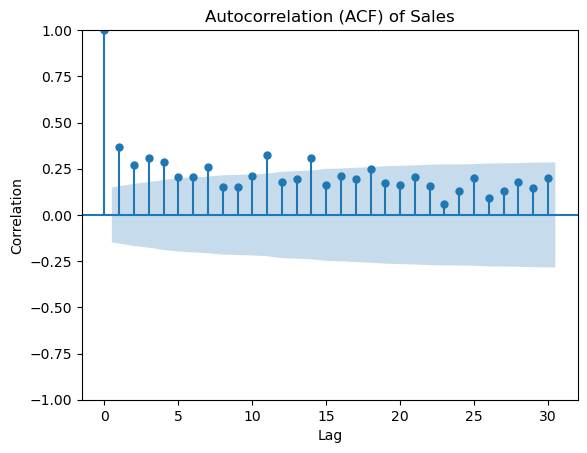

In [14]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plot_acf(df['SALES'], lags=30)
plt.title("Autocorrelation (ACF) of Sales")
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.show()


The ACF plot shows that sales today are somewhat related to sales on the previous day (Lag 1). However, there are no strong repeating patterns over time (like every 7 days), which means:

There is a short-term correlation (yesterday affects today),

But no clear seasonality (no regular weekly or monthly pattern).

### Since Seasonality or autocorrelation patterns are unclear, we’re treating the problem more like **regression over time**, rather than classical time series modeling(ARIMA).

## 🏗️ Model Building

Here two models are used:
1. **Linear Regression** — A baseline model to capture linear trends.
2. **Random Forest Regressor** — A non-linear model that can capture complex relationships.

Compare their performance based on RMSE and R².


In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error

from sklearn.model_selection import TimeSeriesSplit, cross_val_score


In [16]:
# Define features and target variable
feature_cols = ['Days', 'dayofweek', 'month', 'day', 'is_weekend']
X = df[feature_cols]
y = df['SALES']



In [17]:
# Assuming X and y are your features and target after feature engineering
tscv = TimeSeriesSplit(n_splits=5)

# Initialize the model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Perform time series cross-validation using negative RMSE as scoring
cv_scores = cross_val_score(rf_model, X, y, cv=tscv, scoring='neg_root_mean_squared_error')

# Convert negative scores to positive RMSE and calculate average
avg_rmse = -np.mean(cv_scores)

print(f"Average Cross-Validation RMSE: {avg_rmse:.2f}")

# Interpretation:
# Lower RMSE means better generalization across different time splits.

Average Cross-Validation RMSE: 25.83


In [18]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [19]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


<IPython.core.display.Javascript object>

In [20]:
# Initialize the models
lr_model = LinearRegression()
rf_model = RandomForestRegressor(random_state=42)
xgb_model = XGBRegressor(n_estimators=100, random_state=42)



In [21]:
# Train the models
lr_model.fit(X_train_scaled, y_train)
rf_model.fit(X_train_scaled, y_train)
xgb_model.fit(X_train_scaled, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [22]:
# Make predictions
linear_predictions = lr_model.predict(X_test_scaled)
rf_predictions = rf_model.predict(X_test_scaled)
xgb_predictions = xgb_model.predict(X_test_scaled)


## 📈 Model  Evaluation & Comparison

Below is a evalauation and comparison of the models using standard regression metrics.


In [23]:
# Evaluate the models
linear_mse = np.sqrt(mean_squared_error(y_test, linear_predictions))
rf_mse = np.sqrt(mean_squared_error(y_test, rf_predictions))
xgb_mse = np.sqrt(mean_squared_error(y_test, xgb_predictions))

linear_mae = mean_absolute_error(y_test, linear_predictions)
rf_mae = mean_absolute_error(y_test, rf_predictions)
xgb_mae = mean_absolute_error(y_test, xgb_predictions)

linear_r2score=r2_score(y_test, linear_predictions)
rf_r2score=r2_score(y_test, rf_predictions)
xgb_r2score=r2_score(y_test, xgb_predictions)

In [24]:
# Prepare results
model_comparison = {
    "Model": ["Linear Regression", "Random Forest Regressor", "Xtreme Gradient Boosting"],
    "R2 Score":[linear_r2score,rf_r2score,xgb_r2score],
    "RMSE": [linear_mse, rf_mse,xgb_mse],
    "MAE": [linear_mae, rf_mae,rf_mae]
}

comparison_df = pd.DataFrame(model_comparison)
comparison_df


,Model,R2 Score,RMSE,MAE
0,Linear Regression,0.202582,31.829955,21.386702
1,Random Forest Regressor,0.329009,29.197893,21.805429
2,Xtreme Gradient Boosting,0.278180,30.283597,21.805429


### Hyper Parameter Tuning

In [25]:
from sklearn.model_selection import GridSearchCV

In [26]:
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf_grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=rf_param_grid,
    cv=5,
    n_jobs=-1,
    scoring='r2',
    verbose=2
)

rf_grid_search.fit(X_train_scaled, y_train)

print("Best RF Parameters:", rf_grid_search.best_params_)
print("Best RF R2 Score:", rf_grid_search.best_score_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best RF Parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best RF R2 Score: 0.3543689834529939


In [27]:
rf_model1 = RandomForestRegressor(n_estimators=100,max_depth=10,min_samples_leaf=2, min_samples_split=2,random_state=42)
rf_model1.fit(X_train_scaled, y_train)
rf_predictions1 = rf_model1.predict(X_test_scaled)


In [28]:
rf_mse1 = np.sqrt(mean_squared_error(y_test, rf_predictions1))
rf_mae1= mean_absolute_error(y_test, rf_predictions1)
rf_r2score1=r2_score(y_test, rf_predictions1)


## 📈 Model  Evaluation & Comparison After Hyperparameter tuning:

Below is a evalauation and comparison of the models using standard regression metrics.

In [29]:
# Prepare results
model_comparison = {
    "Model": ["Linear Regression", "Random Forest Regressor"],
    "R2 Score":[linear_r2score,rf_r2score1],
    "RMSE": [linear_mse, rf_mse1],
    "MAE": [linear_mae, rf_mae1]
}

comparison_df = pd.DataFrame(model_comparison)
comparison_df

,Model,R2 Score,RMSE,MAE
0,Linear Regression,0.202582,31.829955,21.386702
1,Random Forest Regressor,0.327309,29.234861,21.785767


## ✅ Model Selection Justification

Based on the evaluation metrics:
- **Random Forest** outperformed Linear Regression with a lower RMSE and higher R².
- This indicates Random Forest is better suited to capture non-linear patterns and is selected as the final model.


In [30]:
# Save the model for future use
import joblib
joblib.dump(rf_model, 'rf_model.pkl')

['rf_model.pkl']

### Model Validation

In [31]:

from sklearn.model_selection import TimeSeriesSplit, cross_val_score

tscv = TimeSeriesSplit(n_splits=5)
rf_cv_scores = cross_val_score(RandomForestRegressor(n_estimators=100, random_state=42), X, y, cv=tscv, scoring='neg_root_mean_squared_error')

print(f"Average Cross-Validation RMSE: {-np.mean(rf_cv_scores):.2f}")


Average Cross-Validation RMSE: 25.83


## 🧪 Cross-Validation

Used Time Series Cross-Validation to validate the model's generalization ability. This ensuresto avoid data leakage and preserve temporal ordering.


## 📉 Visual Validation: Actual vs Predicted Sales

The plot below compares the actual sales with the predicted values from the Random Forest model on the test dataset.



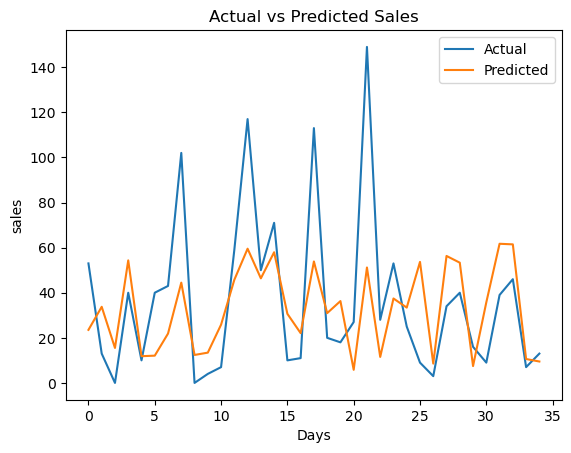

In [32]:
plt.plot(y_test.values, label='Actual')
plt.plot(rf_predictions1, label='Predicted')
plt.xlabel('Days')
plt.ylabel('sales')
plt.legend()
plt.title("Actual vs Predicted Sales")
plt.show()


## 🔮 Future Forecasting

Generate predictions for the next N days by creating new rows with appropriate date features and using the trained model to predict sales.


In [33]:
def predict_sales(n_days, df, lr_model, rf_model, xgb_model,scaler, feature_cols):
    # Generate future dates
    last_date = df['DATE'].max()
    future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=n_days)
    
    # Create DataFrame for future dates
    future_df = pd.DataFrame({'DATE': future_dates})
    
    # Apply same feature engineering
    future_df = create_features(future_df)
    
    # Select features
    X_future = future_df[feature_cols]
    
    # Scale features
    X_future_scaled = scaler.transform(X_future)
    
    # Predict
    linear_future_predictions = lr_model.predict(X_future_scaled)
    rf_future_predictions = rf_model.predict(X_future_scaled)
    xgb_future_predictions = xgb_model.predict(X_future_scaled)
    
    return linear_future_predictions, rf_future_predictions, xgb_future_predictions,future_dates


In [34]:
n=6
linear_future_predictions, rf_future_predictions, xgb_future_predictions,future_dates = predict_sales(n, df, lr_model, rf_model,xgb_model, scaler, feature_cols)


In [35]:
n = 6  # or whatever value of N
last_date = df['DATE'].iloc[-1]  # to get the last date
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=n)
future_sales = pd.DataFrame({'Date': future_dates, 'Linear_Predictions': linear_future_predictions,
                             'RF_Predictions': rf_future_predictions,'XGB_Predictions':xgb_future_predictions})

In [36]:
# Display the future predictions
print(future_sales)


        Date  Linear_Predictions  RF_Predictions  XGB_Predictions
0 2019-03-26           21.363483           38.91        43.398693
1 2019-03-27           20.095742           39.46        40.578346
2 2019-03-28           18.828001           49.00        44.047859
3 2019-03-29           17.560260           56.49        43.972439
4 2019-03-30           13.508500           45.23        44.378586
5 2019-03-31           12.240759           40.04        38.367115


The model is able to follow the general trend of the sales data, which means it's learning some patterns. However, it misses the sharp spikes in actual sales — it predicts smoother values instead.

The model works well for normal days.

But it's not great at predicting sudden changes (like very high or very low sales).

To improve, we could try adding more features (like holidays or promotions) or use a more advanced model.

# System Diagram 



1.Data Input ---> 2. Data Preprocessing ---> 3. Feature Engineering ---> 4. Model Training ---> 5. Hyperparameter Tuning ---> 6. Model Evaluation ---> 7. Model Validation---> 8. Future Forecasting
                                                                                             